# 🐔 Étude de marché

Une entreprise française d'agroalimentaire spécialisée dans le poulet souhaite se développer à l'international. Sa stratégie mise sur l'exportation, préférable dans un premier temps à une production sur place. Il faudra donc cibler les pays les plus enclins à importer du poulet.

Pour identifier ce groupe de pays, on pourra étudier leurs indicateurs de démographies et régimes alimentaires grâce aux données mises à disposition par la [FAO](http://www.fao.org/home/fr/).


## Sommaire

- [Préparation des données](#Préparation-des-données)
    - [Exploration](#Exploration)
    - [Concaténation et pivot](#Concaténation-et-pivot)
    - [Valeurs manquantes](#Valeurs-manquantes)
    - [Geoplot](#Geoplot)
- [Classification hiérarchique](#Classification-hiérarchique)
    - [Corrélations](#Corrélations)
    - [Normalisation des variables](#Normalisation-des-variables)
    - [ACP à 2 composantes](#ACP-à-2-composantes)
    - [Dendrogramme et clusters](#Dendrogramme-et-clusters)
    - [ACP à 3 composantes](#ACP-à-3-composantes)
    - [Centroïdes](#Centroïdes)
    - [Tests](#Tests)
- [Choix du cluster](#Choix-du-cluster)
    - [5 groupes, par indicateurs protéiques](#5-groupes,-par-indicateurs-protéiques)
    - [4 groupes, par indicateurs de PIB](#4-groupes,-par-indicateurs-de-PIB)
    - [3 groupes, par import / export de poulet](#3-groupes,-par-import-/-export-de-poulet)
    - [2 groupes, par indicateurs démographiques](#2-groupes,-par-indicateurs-démographiques)
- [Groupe sélectionné](#Groupe-sélectionné)
    - [Pays](#Pays)
    - [Sous-groupe](#Sous-groupe)
- [Références](#Références)









In [110]:
pip install pca

Note: you may need to restart the kernel to use updated packages.


In [111]:
# Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import sklearn as sk
import scipy as sp
import pca as pca

In [112]:
sns.set( # Styles Seaborn
    style='whitegrid',
    context='notebook',
    palette='Paired',
    rc={'figure.figsize':(8,5)})

In [113]:
# Couleurs
red_a400 = '#ff1744'
indigo_a100 = '#8c9eff'
indigo_a400 = '#3d5afe'
indigo_a700 = '#304ffe'
bluegrey_900 = '#263238'
teal_a400 = '#1de9b6'
purple_a400 = '#d500f9'
yellow_a400 = '#ffea00'
bluegrey_900 = '#263238'
palette_5 = [teal_a400, indigo_a400, red_a400, yellow_a400, purple_a400]

In [114]:
# Adresse d'enregistrement des graphiques
url_fig = 'graphiques/'

In [115]:
# Affichage des nombres : séparateur des milliers, et réduction du nombre de décimales
# pd.options.display.float_format = '{:,.2f}'.format

# Préparation des données

## Exploration

Quatre jeux de données issus de la page [FAO](). On utilise les jeux en anglais, pour pouvoir utiliser Geoplot à la fin du notebook.

.

In [116]:
url = 'https://raw.githubusercontent.com/gllmfrnr/oc/master/p5/sources/fao_'

# Liste des colonnes non nécessaires qu'on supprimera à l'importation
drop_columns = ['Domain Code', 'Element Code', 'Item Code', 'Flag', 'Flag Description', 'Year Code']

### Nouveaux Bilans Alimentaires

Source : [New Food Balances](http://www.fao.org/faostat/fr/#data/FBS)

Les disponibilités alimentaires par jour et par habitant, en termes de protéines et de calories. On dispose aussi pour chaque apport de la disponibilité des produits animaux uniquement. 

In [117]:
food = pd.read_csv(url + 'new-food-balances.csv').drop(drop_columns, axis=1) 
food

,Domain,Area Code,Area,Element,Item,Year,Unit,Value
0,New Food Balances,2,Afghanistan,Food supply (kcal/capita/day),Grand Total,2018,kcal/capita/day,2040.00
1,New Food Balances,2,Afghanistan,Protein supply quantity (g/capita/day),Grand Total,2018,g/capita/day,55.52
2,New Food Balances,2,Afghanistan,Food supply (kcal/capita/day),Animal Products,2018,kcal/capita/day,191.00
3,New Food Balances,2,Afghanistan,Protein supply quantity (g/capita/day),Animal Products,2018,g/capita/day,10.79
4,New Food Balances,3,Albania,Food supply (kcal/capita/day),Grand Total,2018,kcal/capita/day,3360.00
...,...,...,...,...,...,...,...,...
687,New Food Balances,251,Zambia,Protein supply quantity (g/capita/day),Animal Products,2018,g/capita/day,13.70
688,New Food Balances,181,Zimbabwe,Food supply (kcal/capita/day),Grand Total,2018,kcal/capita/day,1908.00
689,New Food Balances,181,Zimbabwe,Protein supply quantity (g/capita/day),Grand Total,2018,g/capita/day,44.15
690,New Food Balances,181,Zimbabwe,Food supply (kcal/capita/day),Animal Products,2018,kcal/capita/day,159.00


In [118]:
food.info() # Aucune valeur manquante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Domain     692 non-null    object 
 1   Area Code  692 non-null    int64  
 2   Area       692 non-null    object 
 3   Element    692 non-null    object 
 4   Item       692 non-null    object 
 5   Year       692 non-null    int64  
 6   Unit       692 non-null    object 
 7   Value      692 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 43.4+ KB


### Élevage primaire

En tonnes, la production, l'importation et l'exportation de poulet en 2018.

In [119]:
livestock = pd.read_csv(url + 'livestock-primary.csv').drop(drop_columns, axis=1) # Élevage primaire
livestock

,Domain,Area Code,Area,Element,Item,Year,Unit,Value
0,Livestock Primary,2,Afghanistan,Production,"Meat, chicken",2018,tonnes,28850
1,Livestock Primary,2,Afghanistan,Import Quantity,"Meat, chicken",2018,tonnes,23913
2,Livestock Primary,2,Afghanistan,Export Quantity,"Meat, chicken",2018,tonnes,154
3,Livestock Primary,3,Albania,Production,"Meat, chicken",2018,tonnes,15587
4,Livestock Primary,3,Albania,Import Quantity,"Meat, chicken",2018,tonnes,11588
...,...,...,...,...,...,...,...,...
544,Livestock Primary,251,Zambia,Import Quantity,"Meat, chicken",2018,tonnes,10540
545,Livestock Primary,251,Zambia,Export Quantity,"Meat, chicken",2018,tonnes,1387
546,Livestock Primary,181,Zimbabwe,Production,"Meat, chicken",2018,tonnes,65837
547,Livestock Primary,181,Zimbabwe,Import Quantity,"Meat, chicken",2018,tonnes,3758


In [120]:
livestock.info() # Aucune valeur manquante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Domain     549 non-null    object
 1   Area Code  549 non-null    int64 
 2   Area       549 non-null    object
 3   Element    549 non-null    object
 4   Item       549 non-null    object
 5   Year       549 non-null    int64 
 6   Unit       549 non-null    object
 7   Value      549 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 34.4+ KB


### Séries temporelles annuelles

Source : [Annual population](http://www.fao.org/faostat/fr/#data/OA)

Le nombre d'habitants en 2008 et 2018.

In [121]:
population = pd.read_csv(url + 'annual-population.csv').drop(drop_columns, axis=1) # Séries temporelles annuelles
population

,Domain,Area Code,Area,Element,Item,Year,Unit,Value,Note
0,Annual population,2,Afghanistan,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,27722.276,NaN
1,Annual population,2,Afghanistan,Total Population - Both sexes,Population - Est. & Proj.,2018,1000 persons,37171.921,NaN
2,Annual population,3,Albania,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,3002.678,NaN
3,Annual population,3,Albania,Total Population - Both sexes,Population - Est. & Proj.,2018,1000 persons,2882.740,NaN
4,Annual population,4,Algeria,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,34730.608,NaN
...,...,...,...,...,...,...,...,...,...
463,Annual population,249,Yemen,Total Population - Both sexes,Population - Est. & Proj.,2018,1000 persons,28498.683,NaN
464,Annual population,251,Zambia,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,12848.530,NaN
465,Annual population,251,Zambia,Total Population - Both sexes,Population - Est. & Proj.,2018,1000 persons,17351.708,NaN
466,Annual population,181,Zimbabwe,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,12379.549,NaN


In [122]:
population.info() # Aucune valeur manquante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Domain     468 non-null    object 
 1   Area Code  468 non-null    int64  
 2   Area       468 non-null    object 
 3   Element    468 non-null    object 
 4   Item       468 non-null    object 
 5   Year       468 non-null    int64  
 6   Unit       468 non-null    object 
 7   Value      468 non-null    float64
 8   Note       8 non-null      object 
dtypes: float64(1), int64(2), object(6)
memory usage: 33.0+ KB


### Données de la sécurité alimentaire

Le PIB en 2008 et 2018.

In [123]:
security = pd.read_csv(url + 'security-indicators.csv').drop(drop_columns, axis=1) # Données de la sécurité alimentaire
security

,Domain,Area Code,Area,Element,Item,Year,Unit,Value,Note
0,Suite of Food Security Indicators,2,Afghanistan,Value,"Gross domestic product per capita, PPP, dissem...",2008,I$,1587.80,NaN
1,Suite of Food Security Indicators,2,Afghanistan,Value,"Gross domestic product per capita, PPP, dissem...",2018,I$,2190.20,NaN
2,Suite of Food Security Indicators,2,Afghanistan,Value,Political stability and absence of violence/te...,2008,index,-2.69,NaN
3,Suite of Food Security Indicators,2,Afghanistan,Value,Political stability and absence of violence/te...,2018,index,-2.75,NaN
4,Suite of Food Security Indicators,3,Albania,Value,"Gross domestic product per capita, PPP, dissem...",2008,I$,10119.10,NaN
...,...,...,...,...,...,...,...,...,...
759,Suite of Food Security Indicators,251,Zambia,Value,Political stability and absence of violence/te...,2018,index,0.14,NaN
760,Suite of Food Security Indicators,181,Zimbabwe,Value,"Gross domestic product per capita, PPP, dissem...",2008,I$,1739.20,NaN
761,Suite of Food Security Indicators,181,Zimbabwe,Value,"Gross domestic product per capita, PPP, dissem...",2018,I$,3130.00,NaN
762,Suite of Food Security Indicators,181,Zimbabwe,Value,Political stability and absence of violence/te...,2008,index,-1.21,NaN


In [124]:
security.info() # Aucune valeur manquante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Domain     764 non-null    object 
 1   Area Code  764 non-null    int64  
 2   Area       764 non-null    object 
 3   Element    764 non-null    object 
 4   Item       764 non-null    object 
 5   Year       764 non-null    int64  
 6   Unit       764 non-null    object 
 7   Value      764 non-null    float64
 8   Note       0 non-null      float64
dtypes: float64(2), int64(2), object(5)
memory usage: 53.8+ KB


Aucun doublon dans les tables.

In [125]:
def doublons(df): # Nombre de doublons dans la dataframe
    print(len(df) - len(df.drop_duplicates()), 'doublons')

for i in [food, livestock, population, security]:
    doublons(i)

0 doublons
0 doublons
0 doublons
0 doublons


## Concaténation et pivot

Les 4 dataframes ayant les mêmes noms de variables, on commence par les concaténer.

In [126]:
data = pd.concat([food, livestock, population, security]) # Concaténation
data

,Domain,Area Code,Area,Element,Item,Year,Unit,Value,Note
0,New Food Balances,2,Afghanistan,Food supply (kcal/capita/day),Grand Total,2018,kcal/capita/day,2040.00,NaN
1,New Food Balances,2,Afghanistan,Protein supply quantity (g/capita/day),Grand Total,2018,g/capita/day,55.52,NaN
2,New Food Balances,2,Afghanistan,Food supply (kcal/capita/day),Animal Products,2018,kcal/capita/day,191.00,NaN
3,New Food Balances,2,Afghanistan,Protein supply quantity (g/capita/day),Animal Products,2018,g/capita/day,10.79,NaN
4,New Food Balances,3,Albania,Food supply (kcal/capita/day),Grand Total,2018,kcal/capita/day,3360.00,NaN
...,...,...,...,...,...,...,...,...,...
759,Suite of Food Security Indicators,251,Zambia,Value,Political stability and absence of violence/te...,2018,index,0.14,NaN
760,Suite of Food Security Indicators,181,Zimbabwe,Value,"Gross domestic product per capita, PPP, dissem...",2008,I$,1739.20,NaN
761,Suite of Food Security Indicators,181,Zimbabwe,Value,"Gross domestic product per capita, PPP, dissem...",2018,I$,3130.00,NaN
762,Suite of Food Security Indicators,181,Zimbabwe,Value,Political stability and absence of violence/te...,2008,index,-1.21,NaN


On pivote la table en prenant les pays en index, pour obtenir pour obtenir une liste de 238 pays. La **clé primaire** de la table est donc *'Pays'*.

In [127]:
# Table pivot
data = data.pivot_table(index='Area', values='Value', columns=['Element', 'Item', 'Year']).reset_index()
data

Element                       Area Export Quantity  \
Item                                 Meat, chicken   
Year                                          2018   
0                      Afghanistan           154.0   
1                          Albania             NaN   
2                          Algeria             NaN   
3                   American Samoa             NaN   
4                          Andorra             NaN   
..                             ...             ...   
233      Wallis and Futuna Islands             NaN   
234                 Western Sahara             NaN   
235                          Yemen             NaN   
236                         Zambia          1387.0   
237                       Zimbabwe             NaN   

Element Food supply (kcal/capita/day)             Import Quantity  \
Item                  Animal Products Grand Total   Meat, chicken   
Year                             2018        2018            2018   
0                               191.0      2040.0         23913.0   
1                              1003.0      3360.0         11588.0   
2                               390.0      3322.0            27.0   
3                                 NaN         NaN             NaN   
4                                 NaN         NaN             NaN   
..                                ...         ...             ...   
233                               NaN         NaN             NaN   
234                               NaN         NaN             NaN   
235                             142.0      2154.0         95992.0   
236                             159.0      2002.0         10540.0   
237                             159.0      1908.0          3758.0   

Element    Production Protein supply quantity (g/capita/day)              \
Item    Meat, chicken                        Animal Products Grand Total   
Year             2018                                   2018        2018   
0             28850.0                                  10.79       55.52   
1             15587.0                                  61.75      115.74   
2            278279.0                                  24.73       91.83   
3                 NaN                                    NaN         NaN   
4                 NaN                                    NaN         NaN   
..                ...                                    ...         ...   
233               NaN                                    NaN         NaN   
234               NaN                                    NaN         NaN   
235          179768.0                                  10.38       54.52   
236           49487.0                                  13.70       60.53   
237           65837.0                                  11.59       44.15   

Element               Total Population - Both sexes             \
Item    Meat, chicken     Population - Est. & Proj.              
Year             2018                          2008       2018   
0                 NaN                     27722.276  37171.921   
1                 3.0                      3002.678   2882.740   
2                 2.0                     34730.608  42228.408   
3                 NaN                        57.492     55.465   
4                 NaN                        83.862     77.006   
..                ...                           ...        ...   
233               NaN                        13.578     11.661   
234               NaN                       468.633    567.402   
235               NaN                     21892.146  28498.683   
236               NaN                     12848.530  17351.708   
237               2.0                     12379.549  14438.802   

Element                                                                                 Value  \
Item    Gross domestic product per capita, PPP, dissemination (constant 2011 international $)   
Year                                                                                     200

On crée une nouvelle dataframe pour n'y conserver que les variables utiles, et de nouvelles  :

- la croissance de la population entre les 2 années de référence
- le ratio de protéines d'origine animale dans la disponibilité alimentaire protéique 

In [128]:
# Abbréviations du multiIndex
export, imports, production, chicken, kcal, prot, pop, pop2, animal, total, secu, pib, stable = 'Export Quantity', 'Import Quantity', 'Production', 'Meat, chicken', 'Food supply (kcal/capita/day)', 'Protein supply quantity (g/capita/day)', 'Total Population - Both sexes', 'Population - Est. & Proj.', 'Animal Products', 'Grand Total', 'Value', 'Gross domestic product per capita, PPP, dissemination (constant 2011 international $)', 'Political stability and absence of violence/terrorism (index)'
annee_a, annee_b = 2008, 2018

# Nouvelles variables
df = pd.DataFrame()
df['pays'] = data['Area']
df['dispo_calories'] = data[kcal][total][annee_b]
df['dispo_proteines'] = data[prot][total][annee_b]
df['ratio_proteines_animales'] = data[prot][animal][annee_b] / data[prot][total][annee_b]
df['population'] = data[pop][pop2][annee_b] / 1000 # Millions d'habitants
df['population_croissance'] = data[pop][pop2][annee_b] / data[pop][pop2][annee_a]
df['pib'] = data[secu][pib][annee_b]
df['ppa'] = df['pib'] / (df['population'] * 10**6) # PIB / habitant
df['pib_croissance'] = data[secu][pib][annee_b] / data[secu][pib][annee_a]
df['poulet_import-export'] = data[imports][chicken][annee_b] / data[export][chicken][annee_b]
df

,pays,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,ppa,pib_croissance,poulet_import-export
0,Afghanistan,2040.0,55.52,0.194344,37.171921,1.340868,2190.2,0.000059,1.379393,155.279221
1,Albania,3360.0,115.74,0.533523,2.882740,0.960056,13601.3,0.004718,1.344122,NaN
2,Algeria,3322.0,91.83,0.269302,42.228408,1.215885,11479.5,0.000272,1.080424,NaN
3,American Samoa,NaN,NaN,NaN,0.055465,0.964743,NaN,NaN,NaN,NaN
4,Andorra,NaN,NaN,NaN,0.077006,0.918247,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
233,Wallis and Futuna Islands,NaN,NaN,NaN,0.011661,0.858816,NaN,NaN,NaN,NaN
234,Western Sahara,NaN,NaN,NaN,0.567402,1.210760,NaN,NaN,NaN,NaN
235,Yemen,2154.0,54.52,0.190389,28.498683,1.301777,NaN,NaN,NaN,NaN
236,Zambia,2002.0,60.53,0.226334,17.351708,1.350482,3521.5,0.000203,1.281757,7.599135


## Valeurs manquantes

Le ratio de protéines animales dans l'alimentation peut varier de 13% à 73%. Des valeurs manquantes dans les variables autres que *'pays'*. Le plus petit nombre de clés concerne une des variables les plus utiles : *'poulet_import-export'*. Dans cette variable également, on observe des écarts irréguliers entre les quartiles. 

Il y a également des valeurs infinies dans *'poulet_import-export'*.

In [129]:
df.describe(include='all')

,pays,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,ppa,pib_croissance,poulet_import-export
count,238,173.000000,173.000000,173.000000,237.000000,230.000000,185.000000,185.000000,184.000000,116.000000
unique,238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Réunion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2874.554913,82.075376,0.428036,38.357579,1.141948,20870.841622,0.031626,1.208318,inf
std,NaN,454.921695,20.754692,0.158920,161.816211,0.154193,22143.024374,0.121694,0.253684,NaN
min,NaN,1786.000000,42.410000,0.098749,0.000801,0.820026,761.500000,0.000005,0.493578,0.000000
25%,NaN,2563.000000,65.750000,0.286716,0.385637,1.040005,5028.900000,0.000225,1.044927,1.270636
50%,NaN,2857.000000,82.600000,0.442568,5.337962,1.118632,12864.600000,0.001667,1.171460,7.184890
75%,NaN,3277.000000,97.520000,0.559769,19.751466,1.232768,29711.900000,0.010694,1.339931,86.213926


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pays                      238 non-null    object 
 1   dispo_calories            173 non-null    float64
 2   dispo_proteines           173 non-null    float64
 3   ratio_proteines_animales  173 non-null    float64
 4   population                237 non-null    float64
 5   population_croissance     230 non-null    float64
 6   pib                       185 non-null    float64
 7   ppa                       185 non-null    float64
 8   pib_croissance            184 non-null    float64
 9   poulet_import-export      116 non-null    float64
dtypes: float64(9), object(1)
memory usage: 18.7+ KB


In [131]:
print(df[~df.index.isin(df.dropna().index)]['pays'].to_list())

['Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Aruba', 'Bahrain', 'Belize', 'Bermuda', 'Bhutan', 'Bonaire, Sint Eustatius and Saba', 'British Virgin Islands', 'Brunei Darussalam', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Cayman Islands', 'Central African Republic', 'Chad', 'Channel Islands', 'China', 'China, Taiwan Province of', 'Comoros', 'Cook Islands', 'Cuba', 'Curaçao', "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Djibouti', 'Dominica', 'Ecuador', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guyana', 'French Polynesia', 'Gabon', 'Gambia', 'Gibraltar', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy See', 'Iran (Islamic Republic of)', 'Isle of Man', 'Israel', 'Kiribati', "Lao People's Democratic Republic", 'Liberia', 'Libya', 'Liechtenstein', 'Madagascar', 'Malawi', 'Maldives', 'Mali', 'Marshall Islands', '

En choisissant de supprimer toutes les valeurs manquantes et infinies, on ne perd que 2 individus dans les non nuls de *'poulet_import-export'*. On obtient un panel de 106 pays.

In [132]:
df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index().drop(['index'], axis=1)
df.style.background_gradient(cmap='BrBG')

,pays,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,ppa,pib_croissance,poulet_import-export
0,Afghanistan,2040.000000,55.520000,0.194344,37.171921,1.340868,2190.200000,0.000059,1.379393,155.279221
1,Antigua and Barbuda,2445.000000,80.190000,0.645218,0.096286,1.127510,21115.800000,0.219303,0.914029,849.142857
2,Argentina,3307.000000,106.770000,0.646717,44.361150,1.106811,22745.900000,0.000513,0.984513,0.040777
3,Armenia,2997.000000,94.350000,0.480551,2.951745,1.015176,12715.000000,0.004308,1.214712,435.297297
4,Australia,3391.000000,105.940000,0.667359,24.898152,1.167158,49576.000000,0.001991,1.096894,0.145991
5,Austria,3695.000000,109.120000,0.603281,8.891388,1.065918,55687.200000,0.006263,1.041688,1.090448
6,Azerbaijan,3149.000000,94.420000,0.344524,9.949537,1.127826,14209.600000,0.001428,1.101255,54.939689
7,Bahamas,2655.000000,80.690000,0.649399,0.385637,1.122078,35500.500000,0.092057,0.902964,19536.000000
8,Bangladesh,2563.000000,60.730000,0.206817,161.376708,1.118309,4441.400000,0.000028,1.670327,110.500000
9,Barbados,2956.000000,88.690000,0.575262,0.286641,1.023915,15674.900000,0.054685,0.924953,14.460317


## Geoplot

In [133]:
import geopandas as gpd
import geoplot

# Dataset naturalearth_lowres
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).drop(['pop_est', 'gdp_md_est'], axis=1)
world.rename(columns={'name': 'pays'}, inplace=True)

# Harmonisation des noms de pays entre les 2 dataframes
world = world.replace('Russia', 'Russian Federation')
world = world.replace('United Kingdom', 'United Kingdom of Great Britain and Northern Ireland')
world = world.replace('Dominican Rep.', 'Dominican Republic')
world = world.replace('Bolivia', 'Bolivia (Plurinational State of)')
world = world.replace('Bosnia and Herz.', 'Bosnia and Herzegovina')
world = world.replace('South Korea', 'Republic of Korea')
world = world.replace('Macedonia', 'North Macedonia')
world = world.replace('China', 'China, mainland')
world = world.replace('Tanzania', 'United Republic of Tanzania')
world = world.replace('eSwatini', 'Eswatini')
world

,continent,pays,iso_a3,geometry
0,Oceania,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Africa,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Africa,W. Sahara,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,North America,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,North America,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...
172,Europe,Serbia,SRB,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Europe,Montenegro,MNE,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,Europe,Kosovo,-99,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,North America,Trinidad and Tobago,TTO,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


Six pays ne pourront pas être visualisés. 

In [134]:
# Pays non représentables sur la carte
map_missing = df[~df['pays'].isin(world['pays'])]
map_missing

,pays,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,ppa,pib_croissance,poulet_import-export
1,Antigua and Barbuda,2445.0,80.19,0.645218,0.096286,1.127510,21115.8,0.219303,0.914029,849.142857
9,Barbados,2956.0,88.69,0.575262,0.286641,1.023915,15674.9,0.054685,0.924953,14.460317
21,"China, Hong Kong SAR",3267.0,128.53,0.730880,7.371730,1.071182,61071.9,0.008285,1.226619,1.244600
22,"China, Macao SAR",3327.0,109.47,0.647757,0.631636,1.225909,131908.0,0.208835,1.363541,6907.333333
65,Malta,3420.0,116.40,0.567612,0.439248,1.072668,43064.0,0.098040,1.358987,551.600000
83,Samoa,3030.0,87.85,0.592715,0.196129,1.070205,6329.4,0.032272,0.990904,416.000000


On écarte ces 6 pays en ne gardant que les clés de **world**. On obtient une liste finale de 100 pays.

In [135]:
# Jointure entre pays et world
df = world.merge(df.drop(map_missing.index), on='pays')
df

,continent,pays,iso_a3,geometry,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,ppa,pib_croissance,poulet_import-export
0,Oceania,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2781.0,71.14,0.399635,0.883483,1.045096,13808.1,0.015629,1.310489,13.662252
1,Africa,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",2373.0,58.93,0.206007,56.313438,1.345475,2590.0,0.000046,1.363517,43.307692
2,North America,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",3566.0,104.12,0.545044,37.074562,1.112093,48924.4,0.001320,1.061469,1.568819
3,North America,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",3782.0,113.74,0.646035,327.096265,1.077797,61544.4,0.000188,1.111030,0.019352
4,Asia,Kazakhstan,KAZ,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",3067.0,91.49,0.597880,18.319618,1.154929,25544.3,0.001394,1.283627,31.774596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Africa,Egypt,EGY,"POLYGON ((36.86623 22.00000, 32.90000 22.00000...",3292.0,97.52,0.270919,98.423598,1.235917,11366.3,0.000115,1.164162,136.959752
96,Africa,Uganda,UGA,"POLYGON ((33.90371 -0.95000, 31.86617 -1.02736...",1981.0,46.94,0.260971,42.729036,1.404095,2122.1,0.000050,1.208141,0.344573
97,Europe,Bosnia and Herzegovina,BIH,"POLYGON ((18.56000 42.65000, 17.67492 43.02856...",3307.0,98.82,0.374216,3.323925,0.885372,14419.6,0.004338,1.289710,2.181634
98,Europe,North Macedonia,MKD,"POLYGON ((22.38053 42.32026, 22.88137 41.99930...",3072.0,84.49,0.432832,2.082957,1.007567,15944.0,0.007655,1.231777,83.118568


On finit l'exploration en calculant la proportion de la population mondiale couverte par nos données.

In [136]:
pop_2018 = 7592 # Population mondiale en 2018 (millions d'habitants)
print(round(df['population'].sum() / pop_2018 * 100, 1),
      '% de la population mondiale en 2018')

83.2 % de la population mondiale en 2018


# Classification hiérarchique

## Corrélations

Avant de réaliser l'ACP, on peut vérifier la corrélation des variables avec une matrice des corrélations.

Fortes corrélations entre :
- la dispo. en protéines et la dispo. en calories
- la dispo. en protéines et le ratio de protéines animales
- la dispo. en protéines et le PIB

Nous sommes intéressés par les pays les plus susceptibles de consommer du poulet, donc ceux ayant un fort ratio de protéines animales. Les corrélations montrent que ces pays sont susceptibles d'avoir un fort PIB, et de grandes disponibilités en protéines et calories.

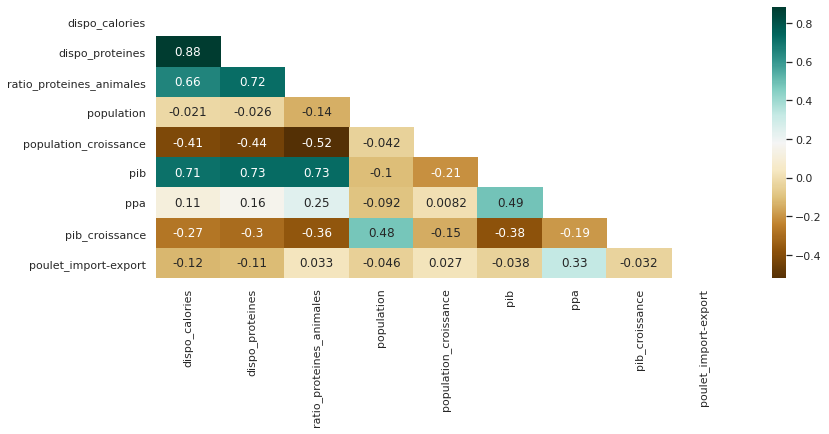

In [137]:
# Calculate pairwise-correlation
matrix = df.corr()

# Triangle de corrélations
mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(13, 5))
sns.heatmap(matrix, mask=mask, annot=True, cmap='BrBG')
plt.show()

## Normalisation des variables

In [138]:
df.describe()

,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,ppa,pib_croissance,poulet_import-export
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3007.800000,86.405200,0.454784,63.200804,1.132678,25095.344000,0.006509,1.197033,426.251852
std,428.917029,18.953652,0.143988,198.734660,0.152900,20884.179617,0.021316,0.218673,2233.638272
min,1981.000000,46.940000,0.141283,0.385637,0.871890,1196.500000,0.000005,0.691271,0.000000
25%,2697.500000,67.255000,0.347529,5.314561,1.029482,8645.525000,0.000259,1.051039,0.838921
50%,3051.000000,86.960000,0.487820,11.483611,1.112964,17899.150000,0.001299,1.185242,4.442613
75%,3343.250000,103.387500,0.568652,44.944077,1.198523,38222.200000,0.004680,1.302479,31.703649
max,3885.000000,126.650000,0.680987,1427.647786,1.755557,114110.000000,0.188847,2.056280,19536.000000


On met de côté les variables déjà basé autour d'un pourcentage.

In [139]:
# normalize() (transfo de la variable entre 0 et 1, sans la cenrter, sans changer la distribution)

# Variables à normaliser et standardiser
categorial = ['continent', 'pays', 'iso_a3', 'geometry']
variables_non_std = df.drop(categorial + ['ratio_proteines_animales', 'population_croissance', 'pib_croissance'], axis=1)
X = variables_non_std.values

from sklearn.preprocessing import normalize
X_scaled = normalize(X)

# Réunion de toutes les variables standardisées
df_std = pd.merge(
    df.drop(variables_non_std.columns, axis=1), # Variables n'ayant pas nécessité une standardisation
    pd.DataFrame(X_scaled, columns=variables_non_std.columns), # Variables précédemment standardisées
    left_index=True, right_index=True)

df_std

,continent,pays,iso_a3,geometry,ratio_proteines_animales,population_croissance,pib_croissance,dispo_calories,dispo_proteines,population,pib,ppa,poulet_import-export
0,Oceania,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.399635,1.045096,1.310489,0.197436,0.005051,0.000063,0.980302,1.109588e-06,9.699478e-04
1,Africa,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0.206007,1.345475,1.363517,0.675311,0.016770,0.016026,0.737065,1.308862e-08,1.232455e-02
2,North America,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.545044,1.112093,1.061469,0.072695,0.002123,0.000756,0.997352,2.690124e-08,3.198127e-05
3,North America,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.646035,1.077797,1.111030,0.061335,0.001845,0.005305,0.998101,3.051400e-09,3.138371e-07
4,Asia,Kazakhstan,KAZ,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",0.597880,1.154929,1.283627,0.119209,0.003556,0.000712,0.992862,5.419664e-08,1.235022e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Africa,Egypt,EGY,"POLYGON ((36.86623 22.00000, 32.90000 22.00000...",0.270919,1.235917,1.164162,0.278157,0.008240,0.008316,0.960394,9.757766e-09,1.157240e-02
96,Africa,Uganda,UGA,"POLYGON ((33.90371 -0.95000, 31.86617 -1.02736...",0.260971,1.404095,1.208141,0.682224,0.016165,0.014715,0.730816,1.710351e-08,1.186654e-04
97,Europe,Bosnia and Herzegovina,BIH,"POLYGON ((18.56000 42.65000, 17.67492 43.02856...",0.374216,0.885372,1.289710,0.223532,0.006680,0.000225,0.974674,2.932297e-07,1.474646e-04
98,Europe,North Macedonia,MKD,"POLYGON ((22.38053 42.32026, 22.88137 41.99930...",0.432832,1.007567,1.231777,0.189190,0.005203,0.000128,0.981913,4.714036e-07,5.118869e-03


Les valeurs sont centrées autour de 0.

In [140]:
df_std.describe()

,ratio_proteines_animales,population_croissance,pib_croissance,dispo_calories,dispo_proteines,population,pib,ppa,poulet_import-export
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000
mean,0.454784,1.132678,1.197033,0.227394,0.006225,0.005891,0.941274,1.907658e-07,0.030906
std,0.143988,0.152900,0.218673,0.192240,0.005115,0.021517,0.105064,3.599276e-07,0.115765
min,0.141283,0.871890,0.691271,0.030351,0.000952,0.000005,0.421799,6.761622e-10,0.000000
25%,0.347529,1.029482,1.051039,0.082764,0.002498,0.000214,0.953808,1.930648e-08,0.000030
50%,0.487820,1.112964,1.185242,0.158154,0.004274,0.000761,0.987013,7.515395e-08,0.000197
75%,0.568652,1.198523,1.302479,0.280879,0.007577,0.003388,0.996512,1.837584e-07,0.002643
max,0.680987,1.755557,2.056280,0.905994,0.029119,0.190422,0.999539,2.266971e-06,0.778994


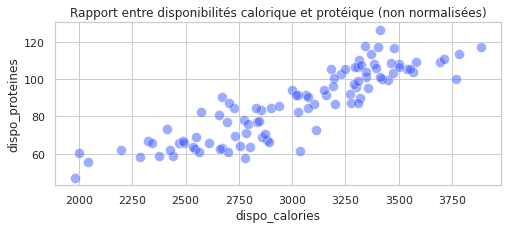

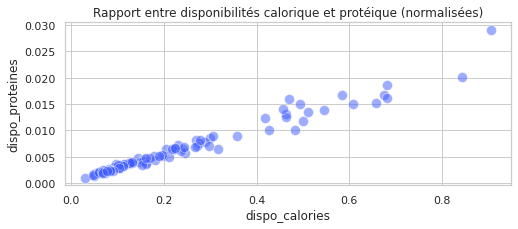

In [141]:
plt.figure(figsize=(8, 3))
sns.scatterplot(data=df, x='dispo_calories', y='dispo_proteines', s=100, alpha=.5, color=indigo_a400)
plt.title('Rapport entre disponibilités calorique et protéique (non normalisées)')
plt.show()

plt.figure(figsize=(8, 3))
sns.scatterplot(data=df_std, x='dispo_calories', y='dispo_proteines', s=100, alpha=.5, color=indigo_a400)
plt.title('Rapport entre disponibilités calorique et protéique (normalisées)')
plt.show()

## ACP à 2 composantes

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [8] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


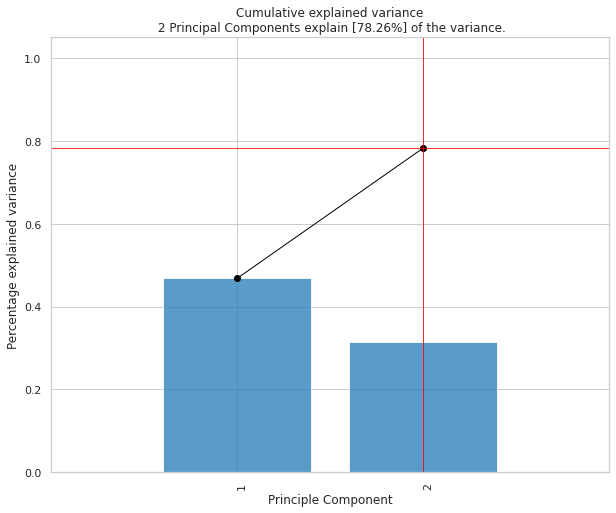

<Figure size 576x360 with 0 Axes>

In [142]:
from pca import pca
model = pca(n_components=2)
results = model.fit_transform(df_std.drop(categorial + ['dispo_calories'], axis=1))
fig, ax = model.plot()
plt.show()

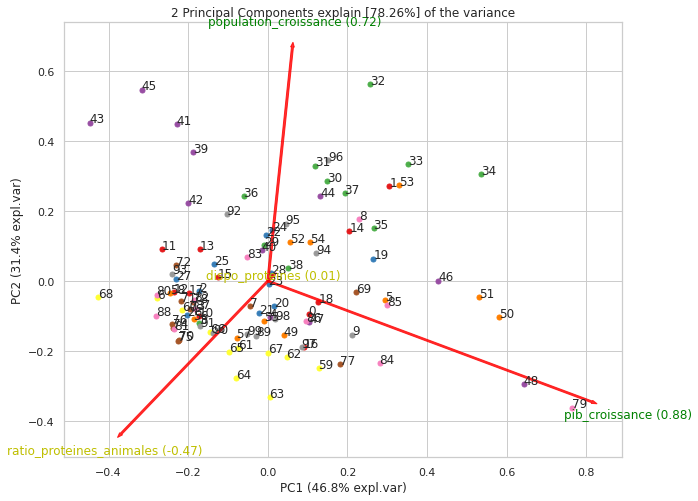

In [143]:
fig, ax = model.biplot(n_feat=4, legend=None)

## Dendrogramme et clusters

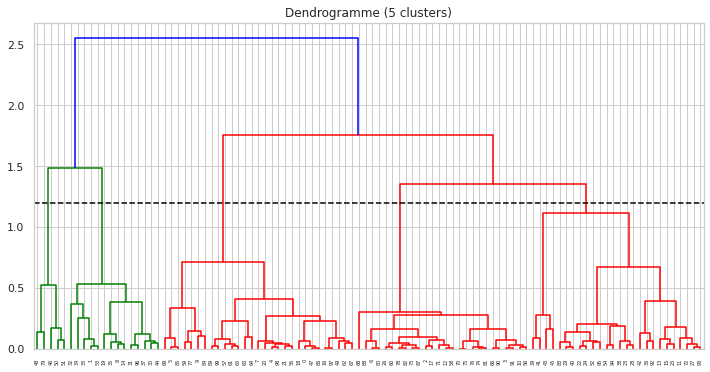

In [144]:
# Dendrogramme sur les 2 composantes de l'ACP
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(12, 6))  
shc.dendrogram(shc.linkage(results['PC'], method='ward'))
plt.axhline(y=1.2, color='black', linestyle='dashed') # Threshold
plt.title('Dendrogramme (5 clusters)')  
plt.savefig('dendrogramme.png', dpi=300, bbox_inches='tight')
plt.show()

In [145]:
# Récupération du cluster de chaque individu
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
clusters = pd.DataFrame(cluster.fit_predict(results['PC']), columns=['cluster'])
deux_composantes = pd.merge(results['PC'], clusters, left_index=True, right_index=True)
deux_composantes = pd.merge(deux_composantes, df['pays'], left_index=True, right_index=True)
deux_composantes

,PC1,PC2,cluster,pays
0,0.102385,-0.095844,2,Fiji
1,0.304909,0.271863,1,United Republic of Tanzania
2,-0.173018,-0.029008,4,Canada
3,-0.171952,-0.119937,4,United States of America
4,0.004607,-0.104050,2,Kazakhstan
...,...,...,...,...
95,0.044333,0.164354,0,Egypt
96,0.150891,0.346455,1,Uganda
97,0.084917,-0.189444,2,Bosnia and Herzegovina
98,0.017925,-0.109169,2,North Macedonia


In [146]:
# Enregistrement de la liste des pays et clusters en CSV
deux_composantes[['pays', 'cluster']].to_csv('groupes_pays.csv')

Avant de représenter l'ACP sur un plan en dimensions, on peut calculer les centroïdes de chaque cluster pour pouvoir vérifier leur position.

In [147]:
# Moyenne par cluster de chaque composante issue de l'ACP (centroïdes)
centroides = deux_composantes.groupby(['cluster']).mean().reset_index()
centroides['cluster'] = 'centroïde'
centroides['pays'] = 'centroïde'
centroides

,cluster,PC1,PC2,pays
0,centroïde,-0.101145,0.147905,centroïde
1,centroïde,0.249013,0.267396,centroïde
2,centroïde,0.064166,-0.152335,centroïde
3,centroïde,0.588717,-0.161360,centroïde
4,centroïde,-0.217723,-0.090945,centroïde


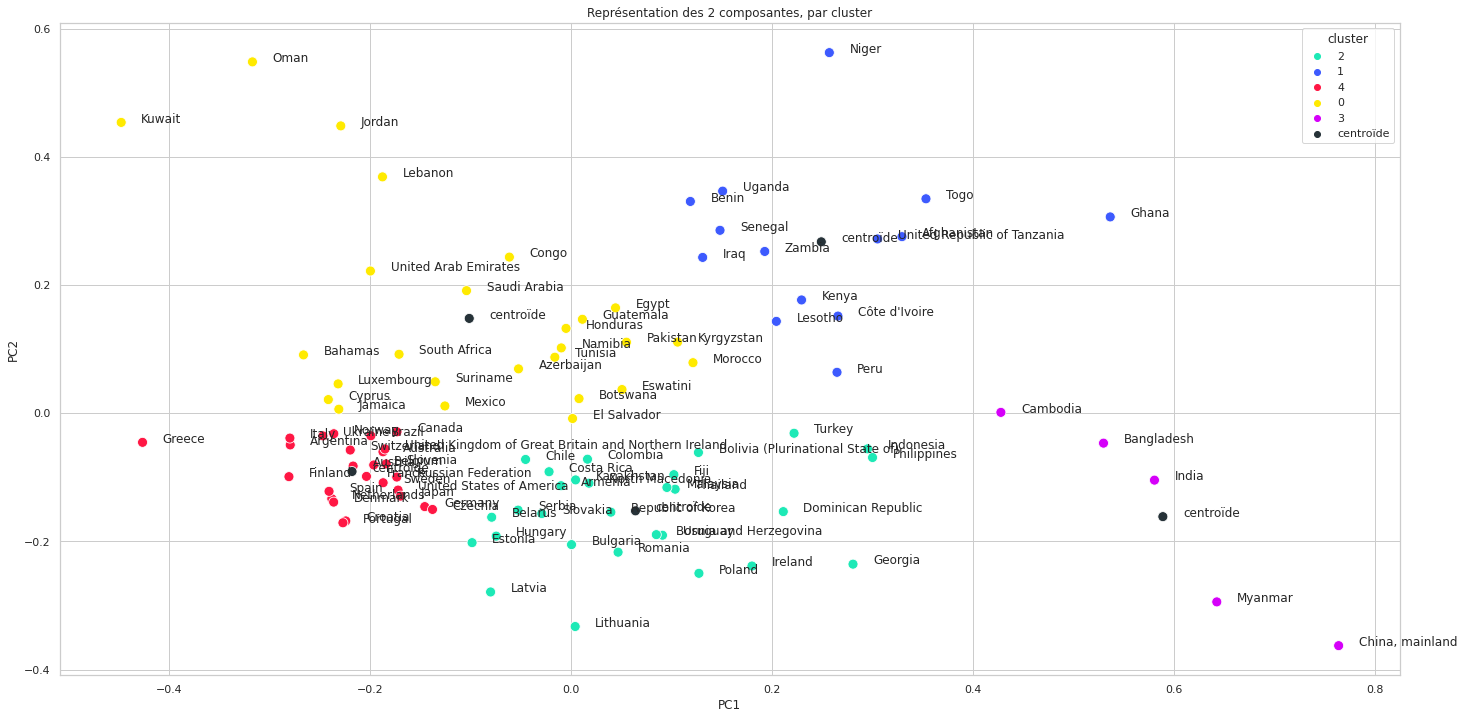

In [148]:
# Jointure des centroïdes sur la dataframe des 2 composantes
deux_composantes_centroides = pd.concat([deux_composantes, centroides])

# Scatterplot des 2 composantes
plt.figure(figsize=(24,12))
ax = sns.scatterplot(data=deux_composantes_centroides, x='PC1', y='PC2', hue='cluster', s=100, 
                     palette=[teal_a400, indigo_a400, red_a400, yellow_a400, purple_a400, bluegrey_900])

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(deux_composantes_centroides['PC1'], deux_composantes_centroides['PC2'], deux_composantes_centroides['pays'], plt.gca())
plt.title('Représentation des 2 composantes, par cluster')
plt.show()

## ACP à 3 composantes

On obtient une meilleure variance expliquée.

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [9] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


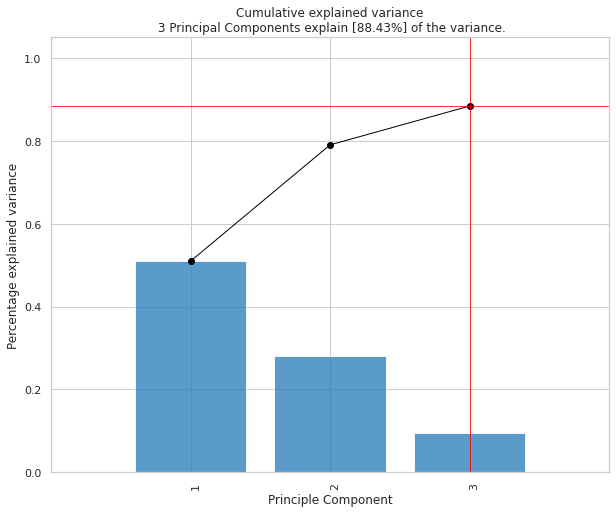

<Figure size 576x360 with 0 Axes>

In [149]:
from pca import pca
model = pca(n_components=3)
results = model.fit_transform(df_std.drop(categorial, axis=1))
fig, ax = model.plot()
plt.show()

Les pays et clusters sont maintenant visualisables dans un espace à 3 dimensions.

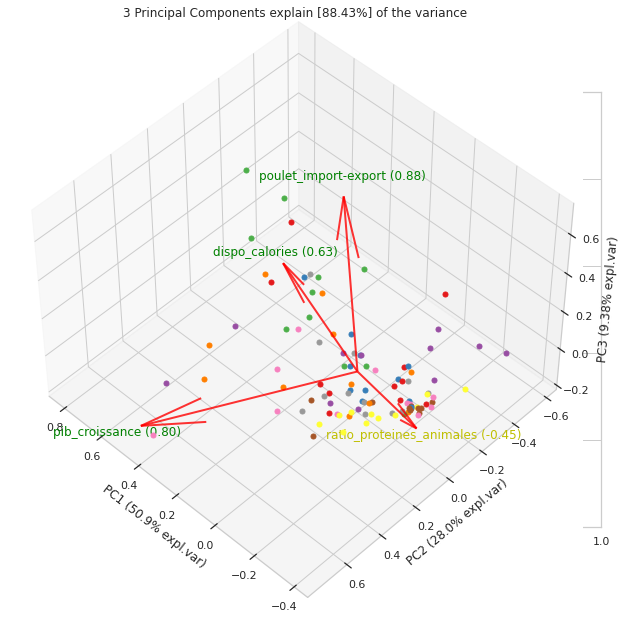

In [150]:
fig, ax = model.biplot3d(n_feat=4, legend=None)
plt.show()

,cluster,PC1,PC2,PC3
0,centroïde,0.527274,-0.175702,0.132564
1,centroïde,-0.048938,0.169027,-0.020562
2,centroïde,0.117840,-0.180521,-0.052167
3,centroïde,-0.244390,-0.051233,0.020508
4,centroïde,0.478453,0.417960,-0.076641


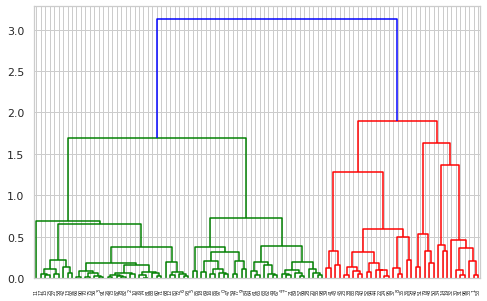

In [151]:
# Dendrogramme sur les 3 composantes de l'ACP
shc.dendrogram(shc.linkage(results['PC'], method='ward'))

# Cluster pour chaque individu
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
clusters = pd.DataFrame(cluster.fit_predict(results['PC']), columns=['cluster'])
trois_composantes = pd.merge(results['PC'], clusters, left_index=True, right_index=True)

# Moyenne par cluster de chaque composante issue de l'ACP
centroides = trois_composantes.groupby(['cluster']).mean().reset_index()
centroides['cluster'] = 'centroïde'
centroides

In [152]:
# Jointure des centroïdes sur la dataframe des 2 composantes
trois_composantes_centroides = pd.concat([trois_composantes, centroides])

# Visualisation des centroïdes
import plotly.express as px
fig = px.scatter_3d(
    pd.concat([trois_composantes_centroides, centroides]), 
    x='PC1', y='PC2', z='PC3', color='cluster', symbol='cluster', opacity=.75)
fig.update(layout_coloraxis_showscale=False)
fig.show()

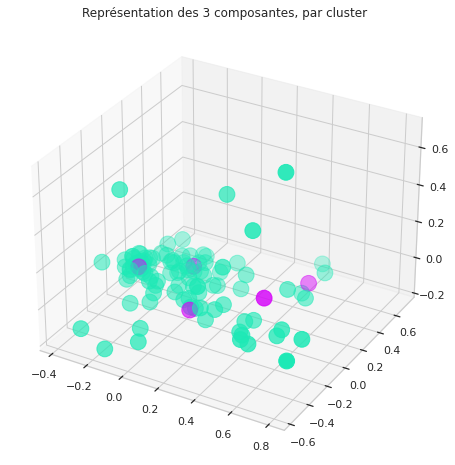

In [153]:
# Jointure des centroïdes sur la dataframe des 2 composantes
centroides['cluster'] = '99' # matplot n'autorise que des valeurs numériques dans 'c='
trois_composantes_centroides = pd.concat([trois_composantes, centroides])

# Représentation avec mplot3d
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(
    trois_composantes_centroides['PC1'].values, 
    trois_composantes_centroides['PC2'].values, 
    trois_composantes_centroides['PC3'].values, 
    c=trois_composantes_centroides['cluster'], s=250,
    cmap=ListedColormap(palette_5))
plt.title('Représentation des 3 composantes, par cluster')
plt.show()

## Centroïdes

On joint les clusters et les coordonnées de l'ACP aux données non normalisées.

In [154]:
# Jointure des données non normalisées avec les clusters et coordonnées de l'ACP
df = pd.merge(df, deux_composantes, how='left', on='pays')
df.sample(3)

,continent,pays,iso_a3,geometry,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,ppa,pib_croissance,poulet_import-export,PC1,PC2,cluster
66,Europe,Germany,DEU,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",3554.0,105.40,0.607495,83.124418,1.025395,53660.0,0.000646,1.127965,1.709913,-0.145402,-0.145715,4
79,Asia,"China, mainland",CHN,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...",3194.0,100.72,0.393666,1427.647786,1.054728,15243.2,0.000011,2.056280,2.832845,0.763558,-0.362629,3
41,Asia,Jordan,JOR,"POLYGON ((35.54567 32.39399, 35.71992 32.70919...",2732.0,69.21,0.335501,9.965318,1.519919,9853.9,0.000989,0.862576,4.723081,-0.228919,0.448250,0


En affichant pour chaque groupe les centroïdes des variables, on peut repérer celles où les moyennes diffèrent.

In [155]:
# Moyenne des variables non standardisées, par cluster
groupes_centroides = df.groupby(['cluster']).mean().reset_index()

# Enregistrement de la liste des pays et clusters en CSV
groupes_centroides.to_csv('groupes_centroides.csv')
groupes_centroides

,cluster,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,ppa,pib_croissance,poulet_import-export,PC1,PC2
0,0,2894.846154,81.646538,0.406025,26.062976,1.237120,22403.076923,0.015457,1.054287,864.207262,-0.101145,0.147905
1,1,2458.928571,62.880000,0.230409,27.856962,1.301356,4304.750000,0.000252,1.299005,1279.513505,0.249013,0.267396
2,2,3106.620690,88.226897,0.503763,29.239332,1.039191,24292.937931,0.004970,1.315441,49.599890,0.064166,-0.152335
3,3,2691.000000,76.278000,0.316439,602.324977,1.109140,7073.980000,0.000079,1.794603,133.146437,0.588717,-0.161360
4,4,3367.000000,103.746923,0.596336,53.572308,1.046210,43343.184615,0.003884,1.037882,5.326090,-0.217723,-0.090945


In [156]:
# Nombre et exemples de pays dans chaque cluster
for i in df.sort_values('cluster')['cluster'].unique():
    print('Cluster', i, ':', len(df[df['cluster']==i]), 'pays\n' + 
        ', '.join(df[df['cluster']==i]['pays'].values), '\n' + '- '*3)

Cluster 0 : 26 pays
Bahamas, South Africa, Mexico, Honduras, El Salvador, Guatemala, Suriname, Jamaica, Botswana, Namibia, Congo, Eswatini, Lebanon, Tunisia, Jordan, United Arab Emirates, Kuwait, Oman, Pakistan, Kyrgyzstan, Luxembourg, Azerbaijan, Saudi Arabia, Cyprus, Morocco, Egypt 
- - - 
Cluster 1 : 14 pays
United Republic of Tanzania, Kenya, Lesotho, Peru, Senegal, Benin, Niger, Togo, Ghana, Côte d'Ivoire, Zambia, Iraq, Afghanistan, Uganda 
- - - 
Cluster 2 : 29 pays
Fiji, Kazakhstan, Indonesia, Chile, Dominican Republic, Uruguay, Bolivia (Plurinational State of), Colombia, Costa Rica, Thailand, Republic of Korea, Armenia, Belarus, Poland, Hungary, Romania, Lithuania, Latvia, Estonia, Bulgaria, Turkey, Ireland, Georgia, Philippines, Malaysia, Slovakia, Bosnia and Herzegovina, North Macedonia, Serbia 
- - - 
Cluster 3 : 5 pays
Cambodia, Myanmar, India, Bangladesh, China, mainland 
- - - 
Cluster 4 : 26 pays
Canada, United States of America, Argentina, Russian Federation, Norway, Br

## Tests

Pour vérifier que les groupes diffèrent réellement, on peut recourir aux tests statistiques. On choisit une variable pertinente : la disponibilité en protéines. Sa médiane est sa moyenne sont très proches, ce qui indique probablement une distribution normale. 

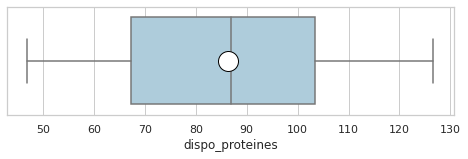

In [157]:
meanprops = {"marker":"o","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"20"}
plt.figure(figsize=(8,2))
sns.boxplot(data=df, x='dispo_proteines', showmeans=True, meanprops=meanprops)
plt.show()

Le test d'ANOVA va nous permettre de vérifier que les moyennes des clusters sont différentes. Pour valider le test, il faudra vérifier la normalité des résidus et l'homogénéité des variances entre clusters.

In [158]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# Test d'ANOVA
sample_df = df.sample(75)
model = smf.ols('dispo_proteines ~ cluster', data=sample_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p = anova_table['PR(>F)'][0]
print('ANOVA\np-value :', p, '\nstat (F) :', anova_table['F'][0])
if p > 0.05:
    print('H0: the means of the samples are equal.')
else:
    print('H1: one or more of the means of the samples are unequal.'
         '\n\nConditions :'
         '\n1. Normalité des résidus\n2. Homoscédasticité')

ANOVA
p-value : 2.6592521071178913e-05 
stat (F) : 20.114269707679476
H1: one or more of the means of the samples are unequal.

Conditions :
1. Normalité des résidus
2. Homoscédasticité


Selon le test de Shapiro, les résidus ne seraient pas distribués normalement.


Normalité des résidus (Shapiro)

stats : 0.9891926646232605 
p-value : 0.7785590291023254
H0 rejetée : distribution probablement pas normale


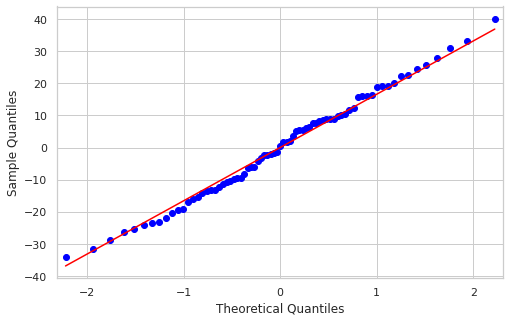

In [159]:
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

# Test de Shapiro sur les résidus
print('\nNormalité des résidus (Shapiro)')
print('\nstats :', stats.shapiro(model.resid)[0],
    '\np-value :', stats.shapiro(model.resid)[1])
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution probablement pas normale')
qqplot(model.resid, line='s')
plt.show()

Après un boxcox, les résidus sont normalement distribués.

Normalité des résidus après boxcox :
stats : nan 
p-value : 1.0
H0 acceptée : distribution normale


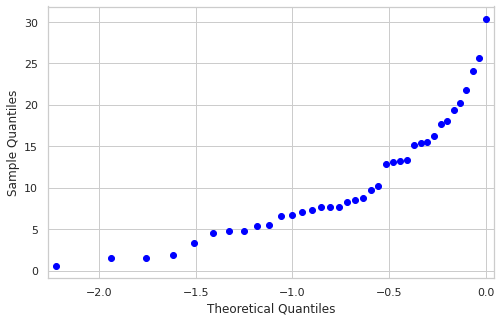

In [160]:
from scipy.special import boxcox1p

# Test de Shapiro sur les résidus après boxcox
residus = boxcox1p(model.resid, .9)
p = stats.shapiro(residus)[1]
print('Normalité des résidus après boxcox :'
    '\nstats :', stats.shapiro(residus)[0],
    '\np-value :', p)
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution probablement pas normale')
qqplot(residus, line='s')
plt.show()

Pour tester l'homoscédasticité, on utilise le test de Levene : les variances des groupes sont probablement égales, ce qui valide notre ANOVA.

In [161]:
# Test de Levene sur les 3 catégories
samples = 5
a = df[df['cluster']==0]['dispo_proteines'].sample(samples).values
b = df[df['cluster']==1]['dispo_proteines'].sample(samples).values
c = df[df['cluster']==2]['dispo_proteines'].sample(samples).values
d = df[df['cluster']==3]['dispo_proteines'].sample(samples).values
e = df[df['cluster']==4]['dispo_proteines'].sample(samples).values

stat, p = stats.levene(a, b, c, d, e)
print('Condition 2 : homoscédasticité (Levene)',
    '\nstats :', stat,
    '\np-value :', p)
if p > 0.05:
    print('H0: les variances sont égales')
else:
    print('H1: les variances ne sont pas égales (essayer Welch ANOVA)')
print('\nConditions :'
      '\n- The samples from the populations under consideration are independent',
      '\n- The populations under consideration are approximately normally distributed') 

Condition 2 : homoscédasticité (Levene) 
stats : 0.21620188915014923 
p-value : 0.9263036535074688
H0: les variances sont égales

Conditions :
- The samples from the populations under consideration are independent 
- The populations under consideration are approximately normally distributed


# Choix du cluster

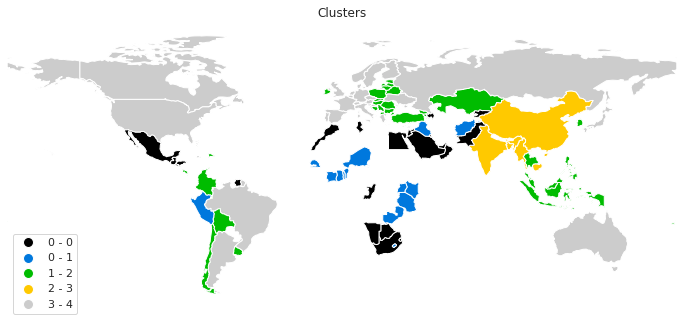

In [162]:
geoplot.choropleth(
    df, hue='cluster', edgecolor='white', linewidth=1,
    cmap='nipy_spectral', legend=True, scheme='FisherJenks', figsize=(12, 15))
plt.title('Clusters')
plt.show()

## 5 groupes, par indicateurs protéiques

Comme vérifié plus tôt, la distributions des disponibilités en protéines varie beaucoup entre groupes. Le cluster 1 affiche des disponibilités beaucoup plus faibles que les 4 autres clusters.

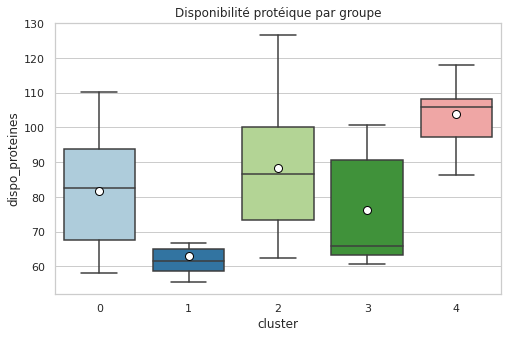

In [163]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=df, y='dispo_proteines', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('Disponibilité protéique par groupe')
plt.show()

Les ratios de protéines animales les plus faibles concernent aussi le cluster 1 : ces pays sont les moins susceptibles de consommer du poulet.

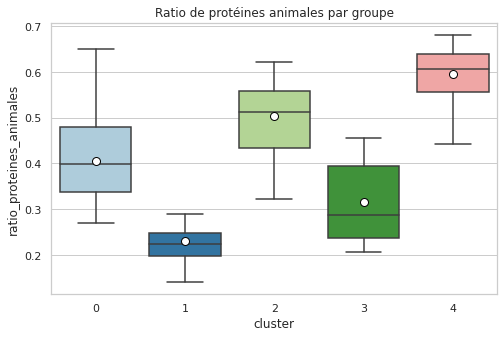

In [164]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=df, y='ratio_proteines_animales', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('Ratio de protéines animales par groupe')
plt.show()

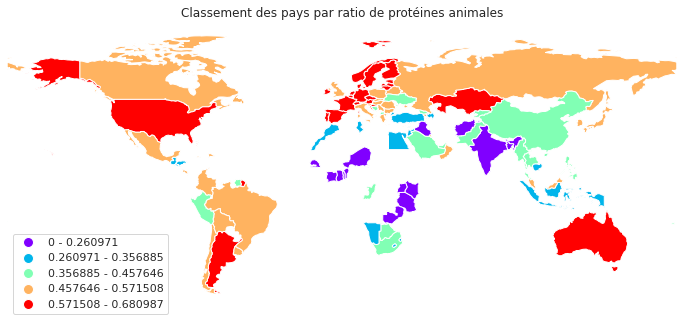

In [165]:
geoplot.choropleth(
    df, hue='ratio_proteines_animales', edgecolor='white', linewidth=1,
    cmap='rainbow', legend=True, scheme='FisherJenks', figsize=(12, 15)
)
plt.title('Classement des pays par ratio de protéines animales')
plt.show()

On élimine ce cluster de l'analyse des autres variables.

In [166]:
print('Cluster à mettre de côté :', df[df['cluster']==1]['pays'].unique())
quatre_groupes = df.drop(df[df['cluster']==1].index)

Cluster à mettre de côté : ['United Republic of Tanzania' 'Kenya' 'Lesotho' 'Peru' 'Senegal' 'Benin'
 'Niger' 'Togo' 'Ghana' "Côte d'Ivoire" 'Zambia' 'Iraq' 'Afghanistan'
 'Uganda']


## 4 groupes, par indicateurs de PIB

Le groupe 3 (Chine, Inde) a la plus forte croissance de PIB, mais le plus faible PIB.

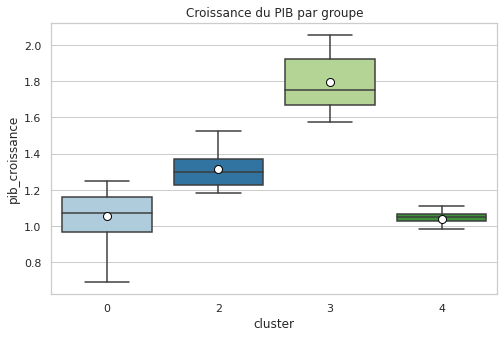

In [167]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=quatre_groupes, y='pib_croissance', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('Croissance du PIB par groupe')
plt.show()

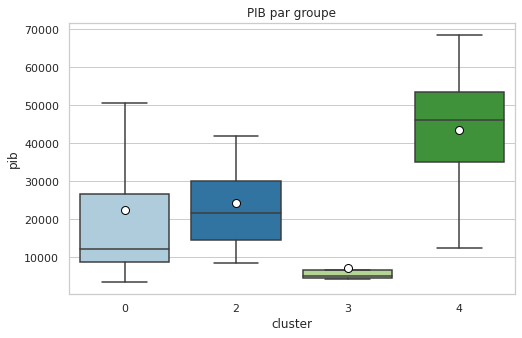

In [168]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=quatre_groupes, y='pib', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('PIB par groupe')
plt.show()

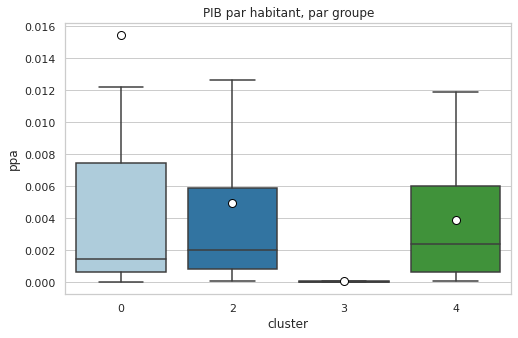

In [169]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=quatre_groupes, y='ppa', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('PIB par habitant, par groupe')
plt.show()

In [170]:
print('Cluster à mettre de côté :', quatre_groupes[quatre_groupes['cluster']==3]['pays'].unique())
trois_groupes = quatre_groupes.drop(quatre_groupes[quatre_groupes['cluster']==3].index)

Cluster à mettre de côté : ['Cambodia' 'Myanmar' 'India' 'Bangladesh' 'China, mainland']


## 3 groupes, par import / export de poulet

Parmi les 3 groupes encore présents, le groupe 4 importe beaucoup moins qu'il n'exporte déjà : on met ce groupe de côté.

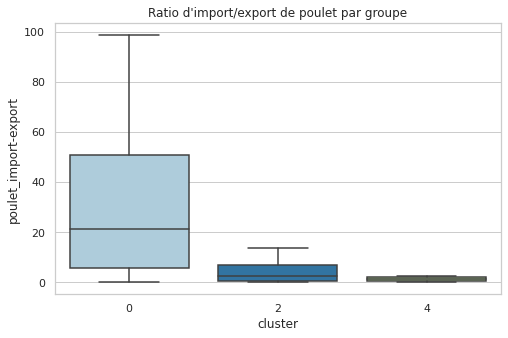

In [171]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=trois_groupes, y='poulet_import-export', x='cluster', showfliers=False)
plt.title('Ratio d\'import/export de poulet par groupe')
plt.show()

In [172]:
print('Cluster à mettre de côté :', trois_groupes[trois_groupes['cluster']==4]['pays'].unique())
deux_groupes = trois_groupes.drop(trois_groupes[trois_groupes['cluster']==4].index)

Cluster à mettre de côté : ['Canada' 'United States of America' 'Argentina' 'Russian Federation'
 'Norway' 'Brazil' 'France' 'Sweden' 'Ukraine' 'Austria' 'Germany'
 'Greece' 'Croatia' 'Switzerland' 'Belgium' 'Netherlands' 'Portugal'
 'Spain' 'Australia' 'Italy' 'Denmark'
 'United Kingdom of Great Britain and Northern Ireland' 'Slovenia'
 'Finland' 'Czechia' 'Japan']


## 2 groupes, par indicateurs démographiques

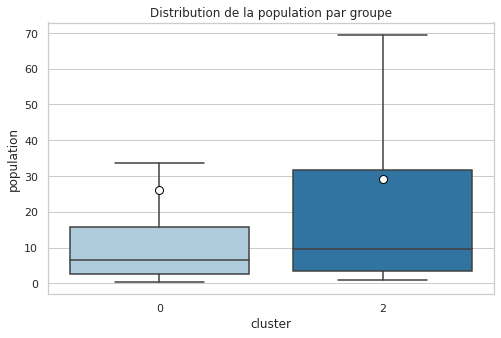

In [173]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=deux_groupes, y='population', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('Distribution de la population par groupe')
plt.show()

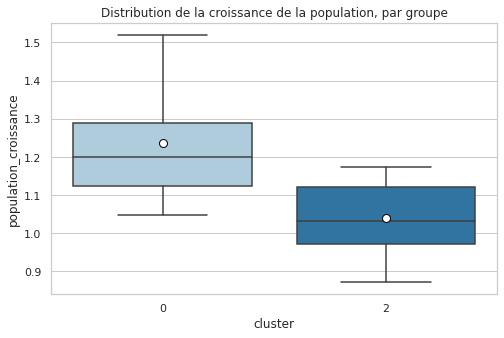

In [174]:
plt.figure(figsize=(8,5))
sns.color_palette('rainbow')
sns.boxplot(
    data=deux_groupes, y='population_croissance', x='cluster', showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('Distribution de la croissance de la population, par groupe')
plt.show()

Le groupe 1, en plus d'afficher une plus forte population que le groupe 2, a également une croissance de population encore plus forte. On choisit donc le groupe 1.

In [175]:
print('Cluster à mettre de côté :', deux_groupes[deux_groupes['cluster']==2]['pays'].unique())
groupe = deux_groupes.drop(deux_groupes[deux_groupes['cluster']==2].index)

Cluster à mettre de côté : ['Fiji' 'Kazakhstan' 'Indonesia' 'Chile' 'Dominican Republic' 'Uruguay'
 'Bolivia (Plurinational State of)' 'Colombia' 'Costa Rica' 'Thailand'
 'Republic of Korea' 'Armenia' 'Belarus' 'Poland' 'Hungary' 'Romania'
 'Lithuania' 'Latvia' 'Estonia' 'Bulgaria' 'Turkey' 'Ireland' 'Georgia'
 'Philippines' 'Malaysia' 'Slovakia' 'Bosnia and Herzegovina'
 'North Macedonia' 'Serbia']


# Groupe sélectionné

## Pays

In [176]:
groupe.sort_values(by='poulet_import-export', ascending=False)

,continent,pays,iso_a3,geometry,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,ppa,pib_croissance,poulet_import-export,PC1,PC2,cluster
11,North America,Bahamas,BHS,"MULTIPOLYGON (((-78.98000 26.79000, -78.51000 ...",2655.0,80.69,0.649399,0.385637,1.122078,35500.5,0.092057,0.902964,19536.000000,-0.266003,0.090974,0
54,Asia,Kyrgyzstan,KGZ,"POLYGON ((70.96231 42.26615, 71.18628 42.70429...",2729.0,84.41,0.401730,6.304030,1.199630,5133.2,0.000814,1.239245,1396.210526,0.106077,0.110937,0
36,Africa,Congo,COG,"POLYGON ((18.45307 3.50439, 18.39379 2.90044, ...",2285.0,58.16,0.453748,5.244359,1.307336,3414.4,0.000651,1.055162,865.287879,-0.061224,0.243556,0
95,Africa,Egypt,EGY,"POLYGON ((36.86623 22.00000, 32.90000 22.00000...",3292.0,97.52,0.270919,98.423598,1.235917,11366.3,0.000115,1.164162,136.959752,0.044333,0.164354,0
28,Africa,Botswana,BWA,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",2342.0,65.89,0.425254,2.254068,1.176666,17634.1,0.007823,1.206501,123.843750,0.008035,0.022772,0
15,North America,Mexico,MEX,"POLYGON ((-117.12776 32.53534, -115.99135 32.6...",3157.0,91.50,0.489399,126.190788,1.138749,19992.2,0.000158,1.085100,98.666176,-0.125376,0.011301,0
83,Asia,Azerbaijan,AZE,"MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...",3149.0,94.42,0.344524,9.949537,1.127826,14209.6,0.001428,1.101255,54.939689,-0.052143,0.069188,0
22,North America,Honduras,HND,"POLYGON ((-83.14722 14.99583, -83.48999 15.016...",2673.0,62.95,0.348531,9.587522,1.201300,5672.3,0.000592,1.131834,37.466830,-0.004875,0.132335,0
24,North America,Guatemala,GTM,"POLYGON ((-92.22775 14.53883, -92.20323 14.830...",2551.0,68.99,0.315263,17.247849,1.231424,8448.5,0.000490,1.147473,36.792619,0.011400,0.146555,0
25,South America,Suriname,SUR,"POLYGON ((-54.52475 2.31185, -55.09759 2.52375...",2698.0,60.73,0.406883,0.575990,1.113836,16609.4,0.028836,1.039283,26.148633,-0.134933,0.049039,0


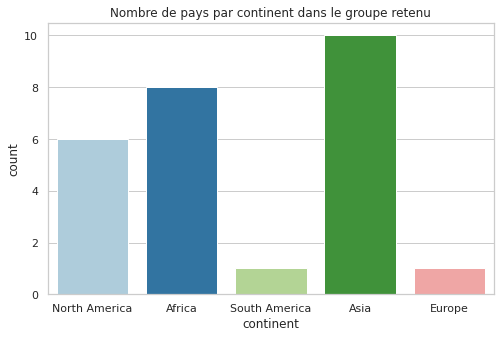

In [177]:
sns.countplot(data=groupe, x='continent')
plt.title('Nombre de pays par continent dans le groupe retenu')
plt.show()

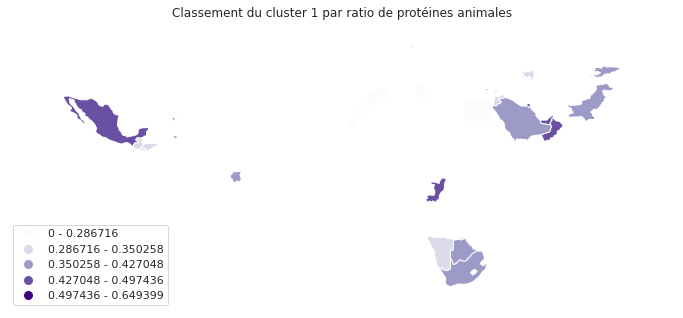

In [178]:
geoplot.choropleth(
    groupe, hue='ratio_proteines_animales', edgecolor='white', linewidth=1,
    cmap='Purples', legend=True, scheme='FisherJenks', figsize=(12, 15)
)
plt.title('Classement du cluster 1 par ratio de protéines animales')
plt.show()

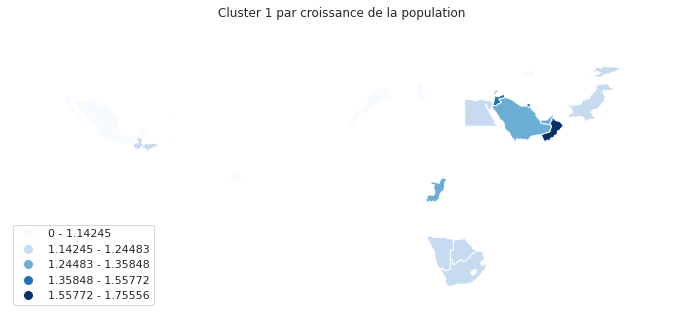

In [179]:
geoplot.choropleth(
    groupe, hue='population_croissance', edgecolor='white', linewidth=1,
    cmap='Blues', legend=True, scheme='FisherJenks', figsize=(12, 15)
)
plt.title('Cluster 1 par croissance de la population')
plt.show()

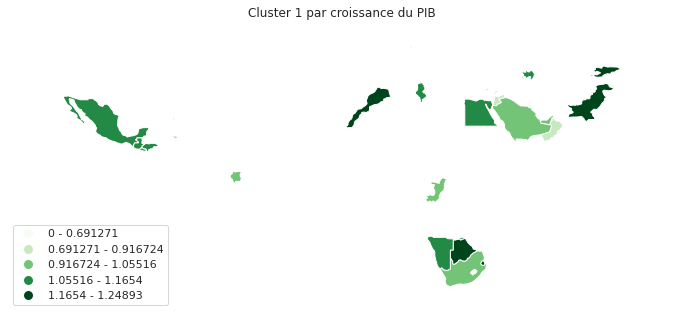

In [180]:
geoplot.choropleth(
    groupe, hue='pib_croissance', edgecolor='white', linewidth=1,
    cmap='Greens', legend=True, scheme='FisherJenks', figsize=(12, 15)
)
plt.title('Cluster 1 par croissance du PIB')
plt.show()

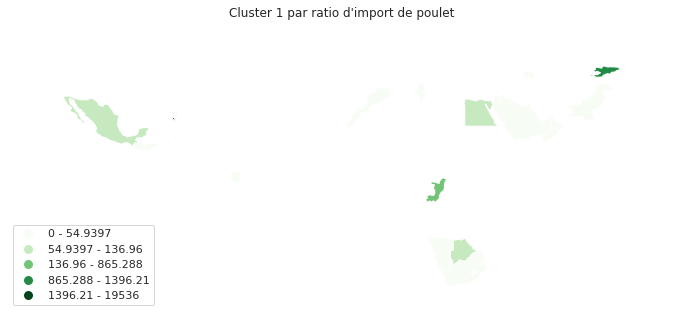

In [181]:
geoplot.choropleth(
    groupe, hue='poulet_import-export', edgecolor='white', linewidth=1,
    cmap='Greens', legend=True, scheme='FisherJenks', figsize=(12, 15)
)
plt.title('Cluster 1 par ratio d\'import de poulet')
plt.show()

## Sous-groupe

Dans un premier temps et pour limiter l'impact des transports, on peut se restreindre à l'Afrique et à l'Asie.

In [182]:
groupe_sub = groupe[groupe['continent'].isin(['Africa', 'Asia'])]
groupe_sub

,continent,pays,iso_a3,geometry,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,ppa,pib_croissance,poulet_import-export,PC1,PC2,cluster
13,Africa,South Africa,ZAF,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082...",2899.0,84.37,0.427048,57.792518,1.160971,12630.8,0.000219,1.000206,10.818739,-0.170959,0.091960,0
28,Africa,Botswana,BWA,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",2342.0,65.89,0.425254,2.254068,1.176666,17634.1,0.007823,1.206501,123.843750,0.008035,0.022772,0
29,Africa,Namibia,NAM,"POLYGON ((19.89577 -24.76779, 19.89473 -28.461...",2469.0,65.78,0.350258,2.448301,1.198154,9932.0,0.004057,1.146062,2.086939,-0.009588,0.101883,0
36,Africa,Congo,COG,"POLYGON ((18.45307 3.50439, 18.39379 2.90044, ...",2285.0,58.16,0.453748,5.244359,1.307336,3414.4,0.000651,1.055162,865.287879,-0.061224,0.243556,0
38,Africa,Eswatini,SWZ,"POLYGON ((32.07167 -26.73382, 31.86806 -27.177...",2426.0,62.07,0.281295,1.136281,1.082229,8606.1,0.007574,1.190398,2.642984,0.050778,0.036940,0
39,Asia,Lebanon,LBN,"POLYGON ((35.82110 33.27743, 35.55280 33.26427...",2857.0,69.15,0.324946,6.859408,1.439618,15612.0,0.002276,0.916724,2.381658,-0.187449,0.368703,0
40,Africa,Tunisia,TUN,"POLYGON ((9.48214 30.30756, 9.05560 32.10269, ...",3450.0,99.82,0.286716,11.565201,1.110497,10763.8,0.000931,1.111641,0.882317,-0.016018,0.087344,0
41,Asia,Jordan,JOR,"POLYGON ((35.54567 32.39399, 35.71992 32.70919...",2732.0,69.21,0.335501,9.965318,1.519919,9853.9,0.000989,0.862576,4.723081,-0.228919,0.448250,0
42,Asia,United Arab Emirates,ARE,"POLYGON ((51.57952 24.24550, 51.75744 24.29407...",3314.0,110.26,0.457646,9.630959,1.358485,66968.3,0.006953,0.973399,16.226217,-0.199441,0.221866,0
43,Asia,Kuwait,KWT,"POLYGON ((47.97452 29.97582, 48.18319 29.53448...",3471.0,103.21,0.493847,4.137312,1.557718,50478.6,0.012201,0.691271,21.640911,-0.447314,0.453685,0


On peut alors se limiter à la ceinture du Maroc au Moyen-Orient, formant un sous-groupe de 13 pays.

In [183]:
sous_groupe = groupe_sub.drop(df[df['pays'].isin(['South Africa', 'Namibia', 'Eswatini', 'Congo', 'Botswana'])].index)
sous_groupe.reset_index()

,index,continent,pays,iso_a3,geometry,dispo_calories,dispo_proteines,ratio_proteines_animales,population,population_croissance,pib,ppa,pib_croissance,poulet_import-export,PC1,PC2,cluster
0,39,Asia,Lebanon,LBN,"POLYGON ((35.82110 33.27743, 35.55280 33.26427...",2857.0,69.15,0.324946,6.859408,1.439618,15612.0,0.002276,0.916724,2.381658,-0.187449,0.368703,0
1,40,Africa,Tunisia,TUN,"POLYGON ((9.48214 30.30756, 9.05560 32.10269, ...",3450.0,99.82,0.286716,11.565201,1.110497,10763.8,0.000931,1.111641,0.882317,-0.016018,0.087344,0
2,41,Asia,Jordan,JOR,"POLYGON ((35.54567 32.39399, 35.71992 32.70919...",2732.0,69.21,0.335501,9.965318,1.519919,9853.9,0.000989,0.862576,4.723081,-0.228919,0.448250,0
3,42,Asia,United Arab Emirates,ARE,"POLYGON ((51.57952 24.24550, 51.75744 24.29407...",3314.0,110.26,0.457646,9.630959,1.358485,66968.3,0.006953,0.973399,16.226217,-0.199441,0.221866,0
4,43,Asia,Kuwait,KWT,"POLYGON ((47.97452 29.97582, 48.18319 29.53448...",3471.0,103.21,0.493847,4.137312,1.557718,50478.6,0.012201,0.691271,21.640911,-0.447314,0.453685,0
5,45,Asia,Oman,OMN,"MULTIPOLYGON (((55.20834 22.70833, 55.23449 23...",2940.0,85.36,0.492854,4.829473,1.755557,28593.8,0.005921,0.824112,7.858224,-0.316786,0.548114,0
6,52,Asia,Pakistan,PAK,"POLYGON ((77.83745 35.49401, 76.87172 34.65354...",2486.0,67.00,0.395373,212.228286,1.236409,4739.8,0.000022,1.212659,0.070889,0.055218,0.110807,0
7,54,Asia,Kyrgyzstan,KGZ,"POLYGON ((70.96231 42.26615, 71.18628 42.70429...",2729.0,84.41,0.401730,6.304030,1.199630,5133.2,0.000814,1.239245,1396.210526,0.106077,0.110937,0
8,83,Asia,Azerbaijan,AZE,"MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...",3149.0,94.42,0.344524,9.949537,1.127826,14209.6,0.001428,1.101255,54.939689,-0.052143,0.069188,0
9,92,Asia,Saudi Arabia,SAU,"POLYGON ((34.95604 29.35655, 36.06894 29.19749...",3307.0,86.94,0.376582,33.702756,1.301841,47596.7,0.001412,1.049771,20.916950,-0.103846,0.191193,0


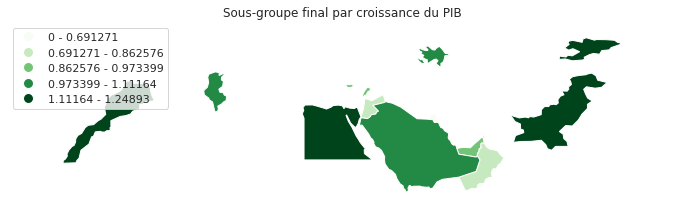

In [184]:
geoplot.choropleth(
    sous_groupe, hue='pib_croissance', edgecolor='white', linewidth=1,
    cmap='Greens', legend=True, scheme='FisherJenks', figsize=(12, 15)
)
plt.title('Sous-groupe final par croissance du PIB')
plt.show()

# Références

- [Agglomerative Clustering and Dendrograms — Explained](https://towardsdatascience.com/agglomerative-clustering-and-dendrograms-explained-29fc12b85f23), Satyam Kumar
- [ANOVA à un facteur - Introduction](http://unt-ori2.crihan.fr/unspf/2010_Limoges_Vignoles_StatsAnova/co/09-1-1-introduction.html)
- [Standardize or Normalize? — Examples in Python](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc)
- [Cours d'ACP : théorie et pratique](https://www.youtube.com/watch?v=8qw0bNfK4H0) (Youtube)
- [A Beginner’s Guide to Hierarchical Clustering and how to Perform it in Python](https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/)